# Adjust image properties

In [9]:
from __future__ import division
import numpy as np
import pandas as pd
from skimage import io, transform, filters, color
from skimage import img_as_uint, img_as_float
from tools import *
import os
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
new_size     = (1024, 1024) # in pixels (width, height)

In [3]:
def mirror_folder(src, dst, file_function=None):
    """Simplified version of shutil.copytree from Python 3"""
    names = os.listdir(src)
    os.makedirs(dst)
    for name in names:
        srcname = os.path.join(src, name)
        dstname = os.path.join(dst, name)
        if os.path.isdir(srcname):
            mirror_folder(srcname, dstname)
        if os.path.isfile(srcname):
            if file_function:
                file_function(srcname, dstname)
    return

def make_filelist(src):
    names = os.listdir(src)
    srclist = []
    for name in names:
        srcname = os.path.join(src, name)
        if os.path.isdir(srcname):
            s = make_filelist(srcname)
            if s:
                srclist = srclist + s
        if os.path.isfile(srcname):
            srclist.append(srcname)
    return srclist

#mirror_folder("/Users/jiri/Local/Sandbox/", "./tmp", make_srclist=True, make_dstlist=True)
#make_filelist("/Users/jiri/Local/Sandbox/")

In [4]:
db_folder = "/Users/jiri/Local/Datasets/SceneStroop/images/"  # must end with /
db_list = make_filelist(db_folder)
db_list_stripped = [f[len(db_folder):] for f in db_list]
db_folder_crop = os.path.join(db_folder, "..", "cropped")
db_folder_processed = os.path.join(db_folder, "..", "processed")

db_prop = pd.DataFrame({"file":db_list_stripped, "file_src":db_list})
db_prop.head()

,file,file_src
0,MH1.jpg,/Users/jiri/Local/Datasets/SceneStroop/images/...
1,MH2.jpg,/Users/jiri/Local/Datasets/SceneStroop/images/...
2,MH3.jpg,/Users/jiri/Local/Datasets/SceneStroop/images/...
3,MH4.jpg,/Users/jiri/Local/Datasets/SceneStroop/images/...
4,MH5.jpg,/Users/jiri/Local/Datasets/SceneStroop/images/...


In [5]:
def inspect_image(fn):
    img = img_as_float(io.imread(fn))
    res = img.shape
    if (len(res) == 2):
        channels = 0
    else:
        channels = res[2]
    lum = np.mean(img)
    contrast = np.sqrt(np.sum((img - lum) ** 2) / (res[0] * res[1]))
    info = {"max":np.max(img), "min":np.min(img), 
            "lum":lum, "contrast":contrast, 
            "w":res[1], "h":res[0], "channels":channels}
    return info
def prepare_crop_and_gray(fn_src, fn_dst, new_size=new_size):
    im = io.imread(fn_src)
    if im.dtype == "O":
        im = im[0]  # ugly hack to overcome old PIL library, pillow should be used http://stackoverflow.com/questions/24089337/skimage-simple-imread-of-image-return-strange-output 
    cropped = crop_and_resize_image(img_as_float(im), new_size, grayscale=True)
    io.imsave(fn_dst, cropped)

#print inspect_image(db_prop["file_src"][0])
#prepare_crop_and_gray(db_prop["file_src"][0], db_prop["file"][0])
#print inspect_image(db_prop["file"][0])

## Make cropped versions

In [67]:
!mkdir $db_folder_crop
for r in range(len(db_prop)):
    f = db_prop["file"][r]
    fn_src = os.path.join(db_folder, f)
    fn_dst = os.path.join(db_folder_crop, f)
    prepare_crop_and_gray(fn_src, fn_dst, new_size)


## Inspect image properties

In [6]:
db_prop["lum"] = 0.
db_prop["contrast"] = 0.
db_prop["min"] = 0.0
db_prop["max"] = 0.0
db_prop["w"] = 0
db_prop["h"] = 0

db_prop.head()

,file,file_src,lum,contrast,min,max,w,h
0,MH1.jpg,/Users/jiri/Local/Datasets/SceneStroop/images/...,0.0,0.0,0.0,0.0,0,0
1,MH2.jpg,/Users/jiri/Local/Datasets/SceneStroop/images/...,0.0,0.0,0.0,0.0,0,0
2,MH3.jpg,/Users/jiri/Local/Datasets/SceneStroop/images/...,0.0,0.0,0.0,0.0,0,0
3,MH4.jpg,/Users/jiri/Local/Datasets/SceneStroop/images/...,0.0,0.0,0.0,0.0,0,0
4,MH5.jpg,/Users/jiri/Local/Datasets/SceneStroop/images/...,0.0,0.0,0.0,0.0,0,0


In [7]:
for r in range(len(db_prop)):
    f = db_prop["file"][r]
    fn_src = os.path.join(db_folder_crop, f)
    info = inspect_image(fn_src)
    # copy only info which has its column in db
    for col in set(info.viewkeys()).intersection(db_prop.columns):
        db_prop.loc[r, col] = info[col]
    

In [8]:
db_prop.head()

,file,file_src,lum,contrast,min,max,w,h
0,MH1.jpg,/Users/jiri/Local/Datasets/SceneStroop/images/...,0.576573,0.395071,0.0,1.0,1024,1024
1,MH2.jpg,/Users/jiri/Local/Datasets/SceneStroop/images/...,0.594222,0.498813,0.0,1.0,1024,1024
2,MH3.jpg,/Users/jiri/Local/Datasets/SceneStroop/images/...,0.570087,0.441075,0.0,1.0,1024,1024
3,MH4.jpg,/Users/jiri/Local/Datasets/SceneStroop/images/...,0.617250,0.445272,0.0,1.0,1024,1024
4,MH5.jpg,/Users/jiri/Local/Datasets/SceneStroop/images/...,0.470032,0.441537,0.0,1.0,1024,1024


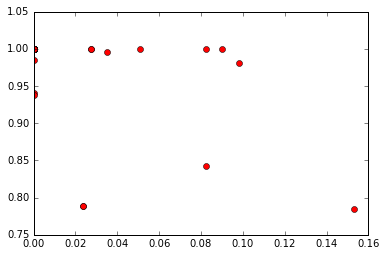

In [11]:
plt.plot(db_prop["min"], db_prop["max"], "ro")

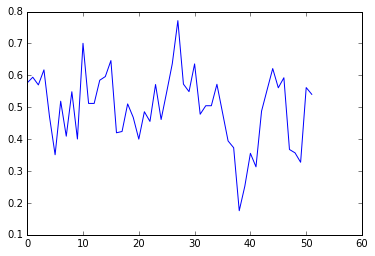

In [13]:
plt.plot(db_prop["lum"])

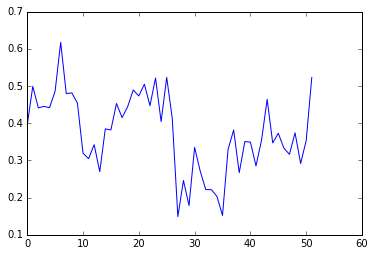

In [12]:
plt.plot(db_prop["contrast"])

In [14]:
db_prop

,file,file_src,lum,contrast,min,max,w,h
0,MH1.jpg,/Users/jiri/Local/Datasets/SceneStroop/images/...,0.576573,0.395071,0.000000,1.000000,1024,1024
1,MH2.jpg,/Users/jiri/Local/Datasets/SceneStroop/images/...,0.594222,0.498813,0.000000,1.000000,1024,1024
2,MH3.jpg,/Users/jiri/Local/Datasets/SceneStroop/images/...,0.570087,0.441075,0.000000,1.000000,1024,1024
3,MH4.jpg,/Users/jiri/Local/Datasets/SceneStroop/images/...,0.617250,0.445272,0.000000,1.000000,1024,1024
4,MH5.jpg,/Users/jiri/Local/Datasets/SceneStroop/images/...,0.470032,0.441537,0.000000,1.000000,1024,1024
5,MM1.jpg,/Users/jiri/Local/Datasets/SceneStroop/images/...,0.351080,0.485906,0.000000,0.941176,1024,1024
6,MM2.jpg,/Users/jiri/Local/Datasets/SceneStroop/images/...,0.518946,0.617337,0.000000,1.000000,1024,1024
7,MM3.jpg,/Users/jiri/Local/Datasets/SceneStroop/images/...,0.409302,0.479621,0.000000,1.000000,1024,1024
8,MM4.jpg,/Users/jiri/Local/Datasets/SceneStroop/images/...,0.548664,0.481437,0.000000,1.000000,1024,1024
9,MM5.jpg,/Users/jiri/Local/Datasets/SceneStroop/images/...,0.400414,0.454013,0.000000,1.000000,1024,1024


In [111]:
db_prop["z_max"] = (db_prop["max"] - db_prop["lum"]) / db_prop["contrast"]
db_prop["z_min"] = (db_prop["min"] - db_prop["lum"]) / db_prop["contrast"]
i_max = np.max(db_prop["z_max"])
i_min = np.min(db_prop["z_min"])
# db_prop["z_max"].hist()

In [114]:
!mkdir $db_folder_processed
for r in range(len(db_prop)):
    f = db_prop["file"][r]
    fn_src = os.path.join(db_folder_crop, f)
    fn_dst = os.path.join(db_folder_processed, f)
    im = img_as_float(io.imread(fn_src))
    imi = (im - db_prop["lum"][r]) / db_prop["contrast"][r]
    imx = (imi - i_min) * 1 / (i_max - i_min)
    io.imsave(fn_dst, imx)

mkdir: /Users/jiri/Local/Datasets/SceneStroop/images/../processed: File exists
